In [1]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/naomiverkerk/TM10007.git


In [2]:
## Import
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from load_data import load_data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Classifiers and kernels
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report



In [106]:
##Loading Data
data = load_data() 
X = data
X = X.replace(np.inf, np.nan)
Y = data['label']
del X['label']

In [107]:
# Check for duplicates values
data.drop_duplicates(keep='first')
print(f'Number of duplicated datasets = {data.duplicated().sum()}')

# Check for duplicates columns
data.columns.drop_duplicates(keep='first')
print(f'Number of duplicated features = {data.columns.duplicated().sum()}')

Number of duplicated datasets = 0
Number of duplicated features = 0


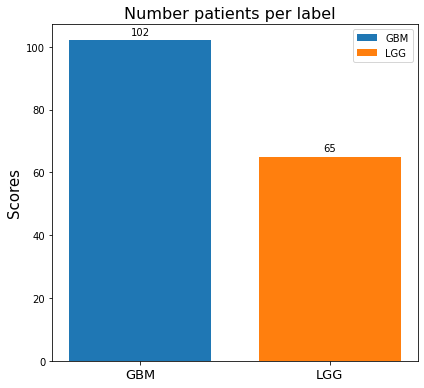

In [5]:
label_count = Y.value_counts()
z = np.arange(len(label_count.index))
width = 0.75
fig, ax = plt.subplots(figsize = (6,5.5))
count1 = ax.bar(0.5, label_count.values[0], width, label=label_count.index[0])
count2 = ax.bar(1.5, label_count.values[1], width, label=label_count.index[1])

ax.set_ylabel('Scores', fontsize = 15)
ax.set_title('Number patients per label  ', fontsize = 16)
ax.set_xticks([0.5,1.5], list(label_count.index), fontsize = 13)
ax.legend()
ax.bar_label(count1, padding=3)
ax.bar_label(count2, padding=3)
ax.grid(False)
fig.tight_layout()

plt.show()


In [6]:
## Split
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size = 0.2, random_state = 4, stratify = Y)

In [125]:
from fitter import Fitter, get_common_distributions, get_distributions
fi = []

col = X.columns
for i in (range(0,X.shape[1],1)):
    try:
        X_tr = X[col[i]].values
        f = Fitter(X_tr,
            distributions=['gamma',
                            'lognorm',
                            "beta",
                            "burr",
                            "norm"])
        f.fit()
        fi.append(list(pd.DataFrame(f.get_best(method = 'sumsquare_error')).columns))
    except Exception:
        pass

flat_list = [item for sublist in fi for item in sublist]
from collections import Counter
Counter(flat_list).most_common()       

KeyboardInterrupt: 

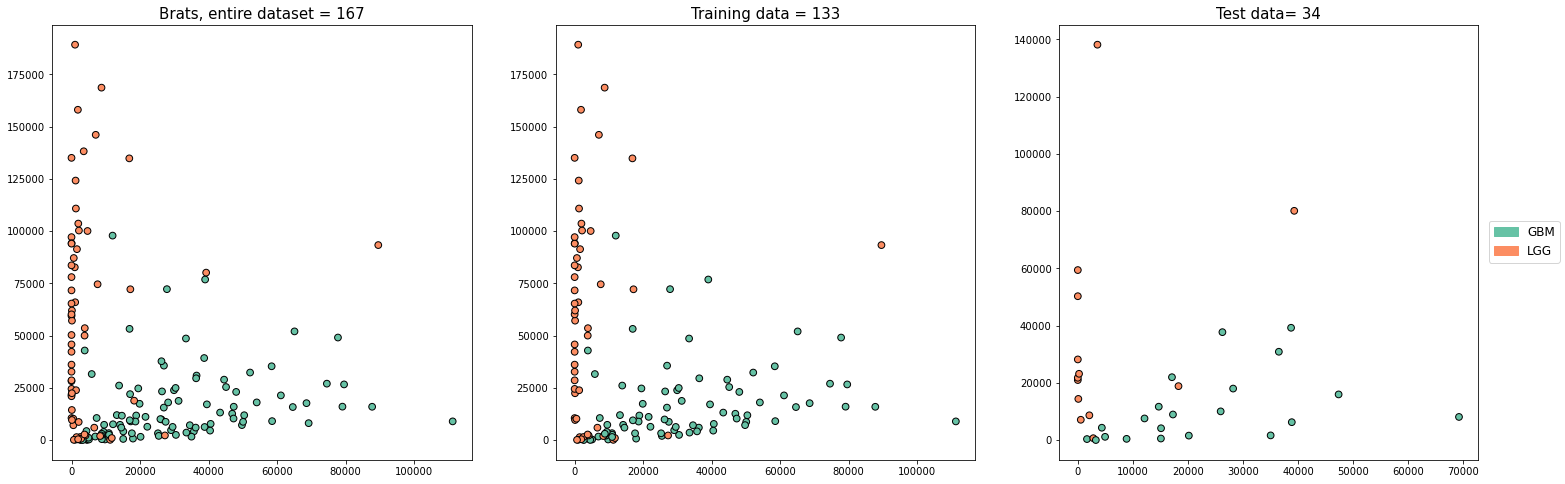

In [7]:
from sklearn import preprocessing
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

le = preprocessing.LabelEncoder()

y_10 = le.fit_transform(Y)
Y_train_10 = le.fit_transform(Y_train)
Y_test_10 = le.fit_transform(Y_test)
# classes = data.label
# classes = list(classes.unique())
colour = sns.color_palette("Set2")
color1=colour[0]
color2=colour[1]

colormap = np.array([color1,color2])

fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(131)
ax.set_title(f"Brats, entire dataset = {len(data)}", fontsize=15)
ax.scatter(data.iloc[:,0], data.iloc[:,1], marker='o', c=colormap[y_10],
           s=45, edgecolor='k', cmap=plt.cm.Paired)

ax = fig.add_subplot(132)
ax.set_title(f"Training data = {len(X_train)}", fontsize=15)
ax.scatter(X_train.iloc[:,0], X_train.iloc[:,1], marker='o', c=colormap[Y_train_10],
           s=45, edgecolor='k', cmap=plt.cm.Paired)

ax = fig.add_subplot(133)
ax.set_title(f"Test data= {len(X_test)}", fontsize=15)
ax.scatter(X_test.iloc[:,0], X_test.iloc[:,1], marker='o', c=colormap[Y_test_10],
           s=45, edgecolor='k', cmap=plt.cm.Paired)   

GBM_patch = mpatches.Patch(color=colour[0], label='GBM')
LGG_patch = mpatches.Patch(color=colour[1], label='LGG')
fig.legend(handles=[GBM_patch, LGG_patch],loc="center right", prop={'size': 12})
fig.subplots_adjust(right=0.95)

plt.show()           

In [8]:

## Features weghalen met teveel missing values
acceptabele_ratio = 0.5
train_size = len(X_train.index)
removal_rate = round(train_size*acceptabele_ratio)

X_train = X_train.dropna(axis=1, thresh=removal_rate)
common_cols = list(set(X_train.columns).intersection(X_test.columns))
X_test = X_test[common_cols]

In [9]:
## Imputation met median
X_train_missing_median = X_train.fillna(X_train.median())
X_train_missing_median = np.nan_to_num(X_train_missing_median)
X_test_missing_median = X_test.fillna(X_test.median())
X_test_missing_median = np.nan_to_num(X_test_missing_median)

In [10]:
## Scaling
scaler = preprocessing.RobustScaler()
scaler.fit(X_train_missing_median)
X_train_scaled = scaler.transform(X_train_missing_median)
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = scaler.transform(X_test_missing_median)
X_test_scaled = np.nan_to_num(X_test_scaled)

In [11]:
## PCA
pca = decomposition.PCA(n_components=0.99, svd_solver= 'full')
pca.fit(X_train_scaled)
X_train_final = pca.transform(X_train_scaled)
X_test_final = pca.transform(X_test_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)


In [ ]:
from sklearn.neural_network import MLPClassifier
import warnings
import seaborn as sns
import statistics
# Create a 20 fold stratified CV iterator

cv_20fold = model_selection.StratifiedKFold(n_splits=5)
results = []
best_n_neighbors = []
n_components = []

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_final, Y_train_final):
    # Split the data properly
    X_validation = X_train_final[validation_index]
    y_validation = Y_train_final[validation_index]

    X_test = X_train_final[test_index]
    y_test = Y_train_final[test_index]

    parameters = {
                    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                    'activation': ['tanh', 'relu'],
                    'solver': ['sgd', 'adam'],
                    'alpha': [0.0001, 0.05],
                    'learning_rate': ['constant','adaptive'],
    }

    clf = MLPClassifier(random_state = 1)
    cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    grid_search = model_selection.GridSearchCV(clf, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)

    clf = grid_search.best_estimator_

    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        "hidden layer sizes": clf.hidden_layer_size,
        "activation": clf.activation,
        "solver": clf.solver,
        "alpha": clf.alpha,
        "learning rate": clf.learning_rate,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc,
        "hidden layer sizes": clf.hidden_layer_size,
        "activation": clf.activation,
        "solver": clf.solver,
        "alpha": clf.alpha,
        "learning rate": clf.learning_rate,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results)

optimal_parameter = []
parameter_keys = list(parameters.keys())

for item in parameter_keys:
    best_item = [] 
    for i in list(range(0,10,2)):
        best_item.append(results[item][i])
    
    optimal_parameter.append(statistics.median(best_item))
    print(f"The optimal {item}={optimal_parameter[-1]}")

results